## 1. t-Sne Analysis of Gold and Synthetic Data

/Users/saishashetty/radenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded: 2425 real reports, 3050 synthetic reports


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


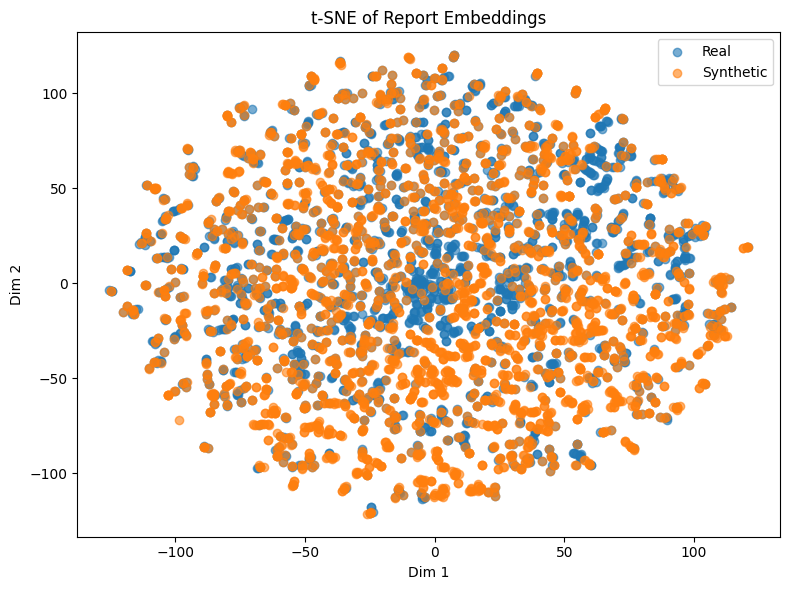

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer

def load_reports_from_file(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)
    return [item["Report"].strip() for item in data if "Report" in item]

# ---- File Paths ----
real_path = "Desktop/data_graph/gold_data.json"
synth_path = "Desktop/data_graph/rag_VALIDATED.json"

# ---- Load ----
real = load_reports_from_file(real_path)
synth = load_reports_from_file(synth_path)

print("Loaded:", len(real), "real reports,", len(synth), "synthetic reports")

# ---- Embedding ----
model = SentenceTransformer("all-MiniLM-L6-v2")
real_emb = model.encode(real, convert_to_numpy=True)
synth_emb = model.encode(synth, convert_to_numpy=True)

X = np.vstack([real_emb, synth_emb])
labels = ["Real"] * len(real) + ["Synthetic"] * len(synth)

# ---- Reduce → 50D PCA, then t-SNE to 2D ----
X_pca = PCA(n_components=min(50, X.shape[1]), random_state=42).fit_transform(X)
X_tsne = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(X_pca)

# ---- Plot ----
plt.figure(figsize=(8, 6))
for label in ["Real", "Synthetic"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label, alpha=0.6)
plt.legend()
plt.title("t-SNE of Report Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

## 2. 3D PCA Scatter: Real vs Synthetic Reports

Loaded: 2425 real, 3050 synthetic


Batches: 100%|██████████████████████████████████| 96/96 [00:01<00:00, 94.91it/s]


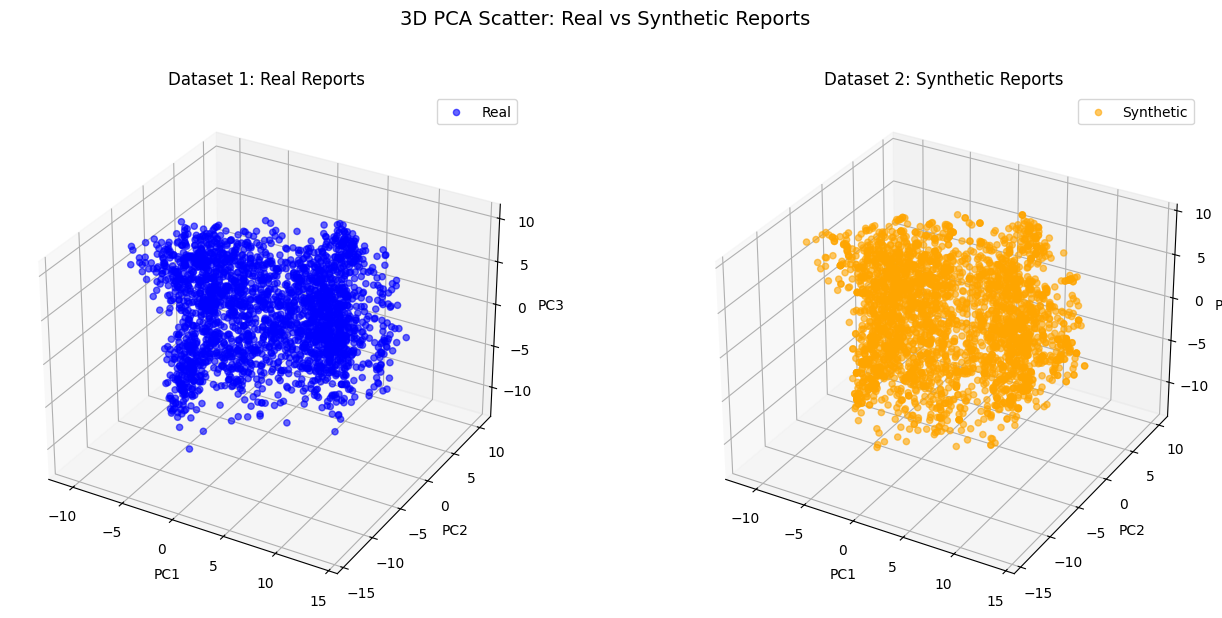

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

def load_reports_from_file(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)
    return [item["Report"].strip() for item in data if "Report" in item]

# -------- Paths --------
real_path = "Desktop/data_graph/gold_data.json"
synth_path = "Desktop/data_graph/rag_VALIDATED.json"


real_reports = load_reports_from_file(real_path)
synth_reports = load_reports_from_file(synth_path)


real_reports = load_reports_from_file(real_path)
synth_reports = load_reports_from_file(synth_path)

print("Loaded:", len(real_reports), "real,", len(synth_reports), "synthetic")

# -------- Embeddings --------
model = SentenceTransformer("all-MiniLM-L6-v2")
real_emb = model.encode(real_reports, convert_to_numpy=True, show_progress_bar=True)
synth_emb = model.encode(synth_reports, convert_to_numpy=True, show_progress_bar=True)

# Combine for PCA
X = np.vstack([real_emb, synth_emb])
labels = np.array(["Real"] * len(real_emb) + ["Synthetic"] * len(synth_emb))

# -------- PCA to 3D --------
X_scaled = StandardScaler().fit_transform(X)
X_pca_3d = PCA(n_components=3).fit_transform(X_scaled)

# -------- Split Again --------
real_3d = X_pca_3d[labels == "Real"]
synth_3d = X_pca_3d[labels == "Synthetic"]

# -------- Plot --------
fig = plt.figure(figsize=(14, 6))

# Left: Real
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(real_3d[:, 0], real_3d[:, 1], real_3d[:, 2], c='blue', alpha=0.6, label='Real')
ax1.set_title("Dataset 1: Real Reports")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
ax1.legend()
ax1.grid(True)

# Right: Synthetic
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(synth_3d[:, 0], synth_3d[:, 1], synth_3d[:, 2], c='orange', alpha=0.6, label='Synthetic')
ax2.set_title("Dataset 2: Synthetic Reports")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")
ax2.legend()
ax2.grid(True)

plt.suptitle("3D PCA Scatter: Real vs Synthetic Reports", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Max cross-set sims (Synthetic → Real)

Loaded: 2425 real, 3050 synthetic


Batches: 100%|██████████████████████████████████| 96/96 [00:00<00:00, 99.72it/s]



Average max similarity scores:
-------------------------------------------
Metric                         |  Score
-------------------------------------------
Avg max intra-set sims (Real)  |  0.850
Avg max intra-set sims (Synth) |  0.914
Avg max cross-set sims (Synth→Real) |  0.877


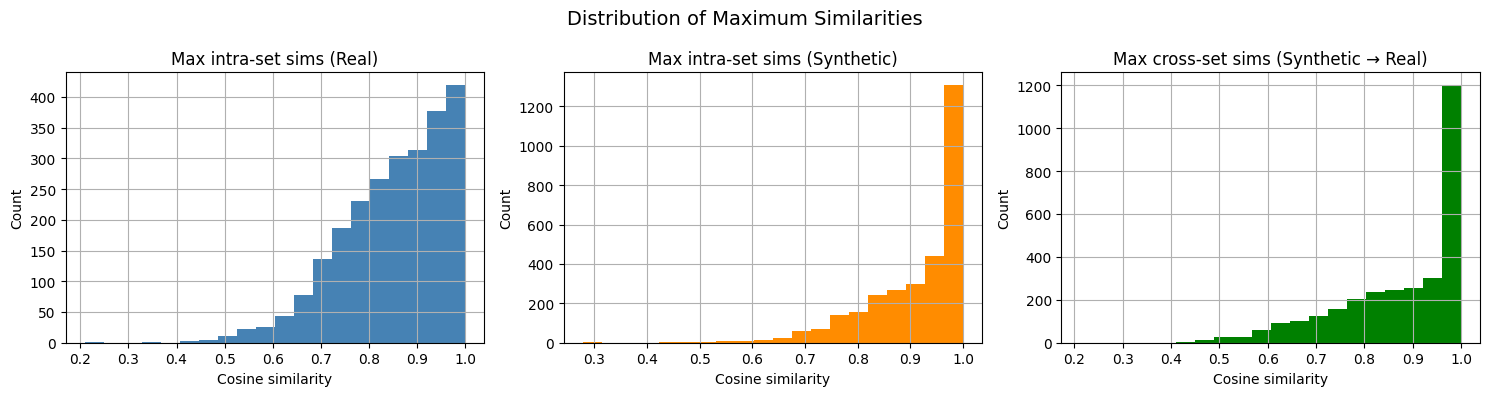

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def load_reports_from_file(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)
    return [item["Report"].strip() for item in data if "Report" in item]

# -------- Load Reports --------
real_path = "Desktop/data_graph/gold_data.json"
synth_path = "Desktop/data_graph/rag_VALIDATED.json"
real_reports = load_reports_from_file(real_path)
synth_reports = load_reports_from_file(synth_path)

print("Loaded:", len(real_reports), "real,", len(synth_reports), "synthetic")

# -------- Embedding --------
model = SentenceTransformer("all-MiniLM-L6-v2")
real_emb = model.encode(real_reports, convert_to_numpy=True, show_progress_bar=True)
synth_emb = model.encode(synth_reports, convert_to_numpy=True, show_progress_bar=True)

# -------- Intra-set Similarities (exclude self) --------
def max_intraset_sims(embeddings):
    sims = cosine_similarity(embeddings)
    np.fill_diagonal(sims, -1.0)  # ignore self-similarity
    return np.max(sims, axis=1)

real_intra = max_intraset_sims(real_emb)
synth_intra = max_intraset_sims(synth_emb)

# -------- Cross-set Similarity (each synthetic → best real) --------
cross_sims = cosine_similarity(synth_emb, real_emb)
cross_max = np.max(cross_sims, axis=1)

# -------- Print Table --------
print("\nAverage max similarity scores:")
print("-------------------------------------------")
print(f"{'Metric':<30} |  Score")
print("-------------------------------------------")
print(f"{'Avg max intra-set sims (Real)':<30} |  {real_intra.mean():.3f}")
print(f"{'Avg max intra-set sims (Synth)':<30} |  {synth_intra.mean():.3f}")
print(f"{'Avg max cross-set sims (Synth→Real)':<30} |  {cross_max.mean():.3f}")

# -------- Plot Histograms --------
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(real_intra, bins=20, color="steelblue")
plt.title("Max intra-set sims (Real)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.hist(synth_intra, bins=20, color="darkorange")
plt.title("Max intra-set sims (Synthetic)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.hist(cross_max, bins=20, color="green")
plt.title("Max cross-set sims (Synthetic → Real)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.grid(True)

plt.suptitle("Distribution of Maximum Similarities", fontsize=14)
plt.tight_layout()
plt.show()


## 4. Number of Report Sentences Containing Each Label Type

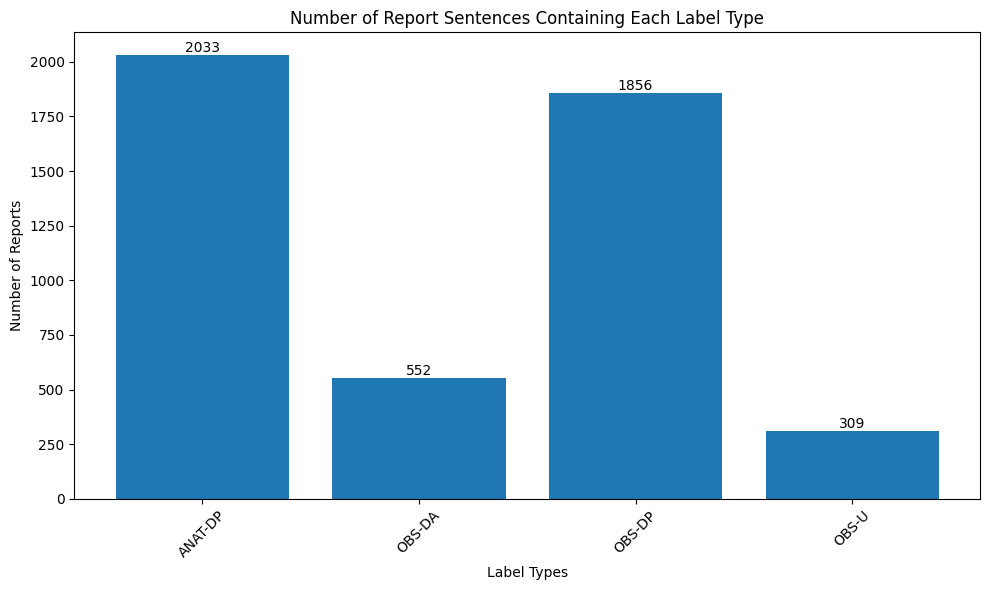


Total reports: 2425

Reports containing each label type:
Reports containing ANAT-DP: 2033 (83.8%)
Reports containing OBS-DA: 552 (22.8%)
Reports containing OBS-DP: 1856 (76.5%)
Reports containing OBS-U: 309 (12.7%)

For negative sampling calculations:
ANAT-DP: 2033 samples
OBS-DP: 1856 samples
OBS-DA: 552 samples
OBS-U: 309 samples


In [5]:
import json
import matplotlib.pyplot as plt
import json
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(json_file):
    """
    Plot distribution of labels from JSON file with "Report" and "Labels" fields
    """
    # Load the JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Count reports containing each label type
    label_report_counts = Counter()
    
    for item in data:
        labels = item.get('Labels', {})
        if isinstance(labels, dict):
            # Get unique label values in this report
            unique_labels = set(labels.values())
            # Count each unique label type once per report
            for label in unique_labels:
                label_report_counts[label] += 1
        elif isinstance(labels, list):
            unique_labels = set(labels)
            for label in unique_labels:
                label_report_counts[label] += 1
        else:
            label_report_counts[labels] += 1
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    labels_sorted = sorted(label_report_counts.keys())
    counts = [label_report_counts[label] for label in labels_sorted]
    
    bars = plt.bar(labels_sorted, counts)
    plt.title('Number of Report Sentences Containing Each Label Type')
    plt.xlabel('Label Types')
    plt.ylabel('Number of Reports')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_samples = len(data)
    print(f"\nTotal reports: {total_samples}")
    print("\nReports containing each label type:")
    for label in labels_sorted:
        count = label_report_counts[label]
        percentage = (count/total_samples) * 100
        print(f"Reports containing {label}: {count} ({percentage:.1f}%)")
    
    return label_report_counts

# Usage:
if __name__ == "__main__":
    # Replace 'your_file.json' with your actual file path
    label_counts = plot_label_distribution('Desktop/data_graph/gold_data.json')
    
    # If you need the counts for negative sampling calculations
    print("\nFor negative sampling calculations:")
    for label, count in label_counts.items():
        print(f"{label}: {count} samples")